In [1]:
import tensorflow as tf
import numpy as np
import os
import re
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cosine
from pyemd import emd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [608]:
data_path = "/Users/Rutherford/Desktop/data"
epsilon = 1e-4

binary_file = os.path.join(data_path,
                           'GoogleNews-vectors-negative300.bin')
w2v_dat = os.path.join(data_path,'embed.dat')
w2v_vocab = os.path.join(data_path,'embed.vocab')

# create word embeddings and mapping of vocabulary item to index
embeddings = np.memmap(w2v_dat, dtype=np.float64,
                            mode="r", shape=(3000000, 300))
with open(w2v_vocab) as f:
    vocab_list = map(lambda string: string.strip(), f.readlines())
vocab_dict = {w: i for i, w in enumerate(vocab_list)}

# mean of 20 rarest words, used as a stand-in for pairwise distances
# if a word is out-of-vocabulary
avg_rare_word = np.mean(np.vstack(embeddings[-20:]),axis=0)
bad_row = np.asarray([avg_rare_word])


In [609]:
#training_set = '/Users/Rutherford/Desktop/data/dataset.csv'

In [610]:
def _get_dist(s_1,s_2):
    """Return counts of in-vocabulary and out-of-vocabulary items per
    string, means of embeddings per string, and Word Mover's Distance
    between the two. Word embeddings and mappings were created upon
    initialization of the class instance, and WMD with emd()
    (Earth Mover's Distance) from PyEMD. Final shape is [1,612].
    """

    results_ = []

    ###############
    #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
    #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
    #s_1 = re.sub(r'\d+','digit',s_1)
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)


    # from FuzzyWuzzy: ratio, partial, sort, set
    fw_ratio = fuzz.ratio(s_1,s_2)
    fw_partial = fuzz.partial_ratio(s_1,s_2)
    fw_sort = fuzz.token_sort_ratio(s_1,s_2)
    fw_set = fuzz.token_set_ratio(s_1,s_2)

    # string lengths for each pair
    str1_len = len(s_1)
    str2_len = len(s_2)

    # combine string metrics together and get scores from _get_dist()
    string_metrics = [fw_ratio,fw_partial,fw_sort,fw_set,str1_len,str2_len]
    results_.extend(string_metrics)

    # moved this up here from mean of word embeddings section
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    results_.extend(S1_)
    results_.extend(S2_)
    ###results_.append(cosine(S1_,S2_))

    #try:
    # fit CV on words with or without a single quote
    vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
    features = np.asarray(vect.get_feature_names())

    # get 'flow' vectors
    v_1, v_2 = vect.transform([s_1, s_2])
    v_1 = v_1.toarray().ravel().astype(np.float64)
    v_2 = v_2.toarray().ravel().astype(np.float64)

    # normalize vectors so as not to reward shorter strings in WMD
    v_1 /= (v_1.sum()+epsilon)
    v_2 /= (v_2.sum()+epsilon)

    # for each out-of-vocabulary item, use the average of the 20
    # rarest words' embeddings to represent it in the distance calc       
    W_ = np.ndarray([0,300])

    # get distance matrix for words in both strings
    for w in features:
        if w in vocab_dict:
            W_ = np.append(W_,embeddings[[vocab_dict[w]]],axis=0)
        else:
            W_ = np.append(W_,bad_row,axis=0)

    # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
    D_euclidean = euclidean_distances(W_).astype(np.float64)
    D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

    # using EMD (Earth Mover's Distance) from PyEMD
    distances_euclidean = emd(v_1,v_2,D_euclidean)
    distances_cosine = emd(v_1,v_2,D_cosine)

    # both WMD calculations (euclidean and cosine)
    results_.append(distances_euclidean)
    results_.append(distances_cosine)

    return results_


In [635]:
training_set = '/Users/Rutherford/Desktop/cleaning_dataset.csv'

In [636]:
# data generation from orginal nn

# original training set cols are Error_type, Str_1, Str_2
X_in = np.genfromtxt(training_set,
              delimiter=',',usecols=(1,2),dtype=str)
Y_in = np.genfromtxt(training_set,
              delimiter=',',usecols=(0)).reshape((-1,1))

X = []
Y = []
bad = []

for i,strings in enumerate(X_in):
    try:
        scores = _get_dist(strings[0],strings[1])
        X.extend(scores)

        # target
        Y.append(Y_in[i])
    except:
        bad.append(i)
        continue

X = np.asarray(X).reshape((-1,608))
Y = np.asarray(Y).reshape((-1,1))

# unshuffled indices
indices = range(X.shape[0])

# randomly shuffle the data
np.random.seed(30)
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

# transform Y from either 1 or 2 to a one-hot vector ([1,0] or [0,1])
y_list = []
for i, label in enumerate(Y):
    if label == 2:
        label = 1
        y_list.append(np.insert(label,0,0))
    elif label == 1:
        y_list.append(np.insert(label,1,0))
    else:
        raise ValueError("Y label must be either 1 (minor) or                                     2 (major). Problem at index ", indices[i])
Y = np.asarray(y_list)

#X,Y,indices,X_in


In [626]:
# sanity checks for wmd distances
print(_get_dist('carp','crap')[-2:])
print(_get_dist('elude','allude')[-2:])
print(_get_dist('dog','puppy')[-2:])
print(_get_dist('snake','serpent')[-2:])
print(_get_dist('this','that')[-2:])
print(_get_dist('he','she')[-2:])
print(_get_dist('and I ran','if I run')[-2:])

[4.770214179148052, 0.8815654487685087]

## RF

In [634]:
# playing with distance calculations.. using only a few features for RF

def dist2(s_1,s_2):
    """Return counts of in-vocabulary and out-of-vocabulary items per
    string, means of embeddings per string, and Word Mover's Distance
    between the two. Word embeddings and mappings were created upon
    initialization of the class instance, and WMD with emd()
    (Earth Mover's Distance) from PyEMD. Final shape is [1,612].
    """

    results_ = []

    ###############
    #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
    #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
    #s_1 = re.sub(r'\d+','digit',s_1)
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)

    # string lengths for each pair
    str1_len = len(s_1)
    str2_len = len(s_2)

    # combine string metrics together and get scores from _get_dist()
    string_metrics = [str1_len,str2_len]
    results_.extend(string_metrics)

    # moved this up here from mean of word embeddings section
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)

    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    results_.append(cosine(S1_,S2_))

    """
    #try:
    # fit CV on words with or without a single quote
    vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
    features = np.asarray(vect.get_feature_names())

    # get 'flow' vectors
    v_1, v_2 = vect.transform([s_1, s_2])
    v_1 = v_1.toarray().ravel().astype(np.float64)
    v_2 = v_2.toarray().ravel().astype(np.float64)

    # normalize vectors so as not to reward shorter strings in WMD
    v_1 /= (v_1.sum()+epsilon)
    v_2 /= (v_2.sum()+epsilon)

    # for each out-of-vocabulary item, use the average of the 20
    # rarest words' embeddings to represent it in the distance calc       
    W_ = np.ndarray([0,300])

    # get distance matrix for words in both strings
    for w in features:
        if w in vocab_dict:
            W_ = np.append(W_,embeddings[[vocab_dict[w]]],axis=0)
        else:
            W_ = np.append(W_,bad_row,axis=0)

    # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
    D_euclidean = euclidean_distances(W_).astype(np.float64)
    D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

    # using EMD (Earth Mover's Distance) from PyEMD
    distances_euclidean = emd(v_1,v_2,D_euclidean)
    distances_cosine = emd(v_1,v_2,D_cosine)

    # both WMD calculations (euclidean and cosine)
    results_.append(distances_euclidean)
    results_.append(distances_cosine)
    """
    return results_


In [ ]:
X2 = []
Y2 = []
bad2 = []

for i,strings in enumerate(X_in):
    try:
        scores = dist2(strings[0],strings[1])
        X2.extend(scores)

        # target
        Y2.append(Y_in[i])
    except:
        bad.append(i)
        continue

X2 = np.asarray(X2).reshape((-1,3))
Y2 = np.asarray(Y2).reshape((-1,1))

In [40]:
Ysecond = Y_in.reshape([-1,])

In [45]:
# unshuffled indices
indices2 = range(X2.shape[0])

# randomly shuffle the data
np.random.seed(30)
np.random.shuffle(indices2)
X2 = X2[indices2]
Y2 = Ysecond[indices2]

In [46]:
validation_size = .2
test_size = .1
# create split indices for validation, test, and train sets
_validation_test_split_idx2 = int(len(Y2)*validation_size)
_train_test_split_idx2 = int(len(Y2)*test_size)+_validation_test_split_idx2

# split data
x2_validation = X2[:_validation_test_split_idx2]
x2_test = X2[_validation_test_split_idx2:
                     _train_test_split_idx2]
x2_train = X2[_train_test_split_idx2:]
y2_validation = Y2[:_validation_test_split_idx2]
y2_test = Y2[_validation_test_split_idx2:
                     _train_test_split_idx2]
y2_train = Y2[_train_test_split_idx2:]

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [251]:
rf = RandomForestClassifier()

NameError: name 'RandomForestClassifier' is not defined

In [47]:
rf.fit(x2_train,y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
rf.score(x2_validation,y2_validation)

0.86239024063275016

In [86]:
print(sum(rf.predict(x2_validation)==2))
print(sum(rf.predict(x2_validation)==1))
print(sum(y2_validation==2))

617
14302
1580


In [87]:
FN_indices = np.where((y2_validation==2) & (rf.predict(x2_validation)==1))[0].tolist()
TP_indices = np.where((y2_validation==2) & (rf.predict(x2_validation)==2))[0].tolist()

In [79]:
tester = []
for i in FN_indices:
    tester.append(indices2[:_validation_test_split_idx2][i])

In [81]:
len(tester)

1508

In [94]:
TPs = [indices2[:_validation_test_split_idx2][i] for i in TP_indices]

In [98]:
sum(y2_validation==2)

1580

In [637]:
#Y_in[TPs]

In [638]:
#X_in[TPs]

## RNN

In [639]:
def dist2(s_1,s_2):

    results_ = []

    ###############
    #s_1 = re.sub(r"\bs\d{0,2}\b",'speaker',s_1)
    #s_1 = re.sub(r"\b\d{5,6}\b",'timestamp',s_1)
    #s_1 = re.sub(r'\d+','digit',s_1)
    s_1 = re.sub(r'-',' ',s_1)
    s_1 = re.sub(r"\ba\b",'one',s_1)

    #s_2 = re.sub(r"\bs\d{0,2}\b",'speaker',s_2)
    #s_2 = re.sub(r"\b\d{5,6}\b",'timestamp',s_2)
    #s_2 = re.sub(r'\d+','digit',s_2)
    s_2 = re.sub(r'-',' ',s_2)
    s_2 = re.sub(r"\ba\b",'one',s_2)
    
    ##### FUZZIES
    
    # string lengths for each pair
    str1_len = len(s_1)
    str2_len = len(s_2)

    # combine string metrics together and get scores from _get_dist()
    string_metrics = [str1_len,str2_len]
    results_.extend(string_metrics)

    # moved this up here from mean of word embeddings section
    s1_features = s_1.split()
    s2_features = s_2.split()

    # sum of indices; proxy for word rarity
    ###results_.append(self._index_check(s1_features))
    ###results_.append(self._index_check(s2_features))        


    # number of out-of-vocabulary and in-vocabulary items
    #s_1_bad = sum(map(lambda word:word not in self.vocab_dict,s1_features))
    #s_1_good = sum(map(lambda word:word in self.vocab_dict,s1_features))
    #s_2_bad = sum(map(lambda word:word not in self.vocab_dict,s2_features))
    #s_2_good = sum(map(lambda word:word in self.vocab_dict,s2_features))
    ###results_.append(s_1_bad)
    ###results_.append(s_1_good)
    ###results_.append(s_2_bad)
    ###results_.append(s_2_good)
    
    #COSINE:
    # mean of word embeddings per string (0s if no items are in embeddings)
    # shape is [1,300] per string
    S1_ = embeddings[[vocab_dict[w] for w in s1_features if w in vocab_dict]]
    S2_ = embeddings[[vocab_dict[w] for w in s2_features if w in vocab_dict]]
    if S1_.shape[0]==0:
        S1_ = np.zeros((1,300))+epsilon
    if S2_.shape[0]==0:
        S2_ = np.zeros((1,300))+epsilon
    S1_ = np.asarray(np.mean(S1_,axis=0)).reshape([-1,1])
    S2_ = np.asarray(np.mean(S2_,axis=0)).reshape([-1,1])
    #results_.extend(S1_)
    #results_.extend(S2_)
    results_.append(cosine(S1_,S2_))


    #try:
    # fit CV on words with or without a single quote
    vect = CountVectorizer(token_pattern='[\w\']+').fit([s_1, s_2])
    features = np.asarray(vect.get_feature_names())

    # get 'flow' vectors
    v_1, v_2 = vect.transform([s_1, s_2])
    v_1 = v_1.toarray().ravel().astype(np.float64)
    v_2 = v_2.toarray().ravel().astype(np.float64)

    # normalize vectors so as not to reward shorter strings in WMD
    v_1 /= (v_1.sum()+epsilon)
    v_2 /= (v_2.sum()+epsilon)

    # for each out-of-vocabulary item, use the average of the 20
    # rarest words' embeddings to represent it in the distance calc       
    W_ = np.ndarray([0,300])

    # get distance matrix for words in both strings
    for w in features:
        if w in vocab_dict:
            W_ = np.append(W_,embeddings[[vocab_dict[w]]],axis=0)
        else:
            W_ = np.append(W_,bad_row,axis=0)

    # use both euclidean and cosine dists (cosine dist is 1-cosine sim)
    D_euclidean = euclidean_distances(W_).astype(np.float64)
    D_cosine = 1.-cosine_similarity(W_,).astype(np.float64)

    # using EMD (Earth Mover's Distance) from PyEMD
    distances_euclidean = emd(v_1,v_2,D_euclidean)
    distances_cosine = emd(v_1,v_2,D_cosine)

    # both WMD calculations (euclidean and cosine)
    results_.append(distances_euclidean)
    results_.append(distances_cosine)

    return results_


In [643]:
#NO COSINE
len(_get_dist('this','that'))

608

In [645]:
validation_size = .2
test_size = .1
# create split indices for validation, test, and train sets
_validation_test_split_idx = int(len(Y)*validation_size)
_train_test_split_idx = int(len(Y)*test_size)+_validation_test_split_idx

# split data
x_validation = X[:_validation_test_split_idx]
x_test = X[_validation_test_split_idx:
                     _train_test_split_idx]
x_train = X[_train_test_split_idx:]
y_validation = Y[:_validation_test_split_idx]
y_test = Y[_validation_test_split_idx:
                     _train_test_split_idx]
y_train = Y[_train_test_split_idx:]
#print(x_validation.shape,x_test.shape,x_train.shape)

In [646]:
def RNN(x, weights, biases, n_hidden):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, n_steps, x)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=.8, state_is_tuple=True)

    # Get lstm cell output
    outputs, states = tf.nn.rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']


In [647]:
# Parameters
learning_rate = 0.001
training_iters = 75#1000#000
batch_size = 32
display_step = 1


# Network Parameters
n_input = 608 # MNIST data input (img shape: 28*28)
n_steps = 1 # timesteps
num_hidden = 128#128 # hidden layer num of features
n_classes = 2 # MNIST total classes (0-9 digits)

In [652]:
def build_graph():
    '''
    To classify images using a recurrent neural network, we consider every image
    row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
    handle 28 sequences of 28 steps for every sample.
    '''

    # tf Graph input
    x = tf.placeholder("float", [None, n_steps, n_input])
    y = tf.placeholder("float", [None, n_classes])

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    start = time()
    pred = RNN(x, weights, biases, num_hidden)

    # Define loss and optimizer
    #########J = sum(sum(6*(y*tf.log(pred))+(1-y)*tf.log(1-pred)))
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    ##ratio = 8034.0 / (66561.0 + 8034.0)
    #class_weight = tf.constant(1.-ratio)#, 1.0 - ratio
    ##class_weight = tf.constant(-ratio)
    ##cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(pred, y, pos_weight=class_weight))
    ### doesn't work but cost = tf.reduce_mean(tf.square(tf.cast(tf.less(pred, y),dtype=tf.float32)))
    
    #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return (x,y),cost,optimizer,pred,accuracy,learning_rate,tf.train.Saver()

In [649]:
sum(Y_in==2)/(sum(Y_in==1)+sum(Y_in==2))

array([0])

In [650]:
def train():
    tf.reset_default_graph()
    (X,Y),cost,train_op,preds,accuracy,lr,saver = build_graph()

    x_train_reshaped = x_train.reshape((-1,n_steps,n_input))
    x_val_reshaped = x_validation.reshape((-1,n_steps,n_input))
    x_test_reshaped = x_test.reshape((-1,n_steps,n_input))
    #x_reshaped = x_train.reshape((-1,n_steps,n_input))
    #x_val = x_validation.reshape((-1,n_steps,n_input))
    #x_test_reshaped = x_test.reshape((-1,n_steps,n_input))
    val_acc_list = [0]
    tr_acc_list = [0]
    val_cost_list = [0]
    tr_cost_list = [0]

    # Launch the graph
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        start_end = zip(range(0,len(x_train),batch_size),
                   range(batch_size,len(x_train)+1,
                         batch_size))
        
        for pass_i in range(training_iters):
            for (s,e) in start_end:

                """batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((batch_size, n_steps, n_input))"""

                ######x_batch = x_train[s:e,].reshape((batch_size,n_steps,n_input))
                # Run optimization op (backprop)
                sess.run(train_op, feed_dict={X: x_train_reshaped[s:e,:,:], Y: y_train[s:e]})
                # Calculate batch accuracy
                #train_acc = sess.run(accuracy, feed_dict={x: x_batch, y: y_train[s:e]})
                # Calculate batch loss
                #train_loss = sess.run(cost, feed_dict={x: x_batch, y: y_train[s:e]})

            #print('validation accuracy: ',sess.run(accuracy, feed_dict={X: x_val_reshaped, Y: y_validation}))

            tr_loss = sess.run(cost, feed_dict={X: x_train_reshaped, Y: y_train})
            tr_acc = sess.run(accuracy, feed_dict={X: x_train_reshaped, Y: y_train})
            val_loss = sess.run(cost, feed_dict={X: x_val_reshaped, Y: y_validation})
            val_acc = sess.run(accuracy, feed_dict={X: x_val_reshaped, Y: y_validation})
            #tes_loss = sess.run(cost, feed_dict={X: x_test_reshaped, Y: y_test})
            #tes_acc = sess.run(accuracy, feed_dict={X: x_test_reshaped, Y: y_test})

            print("Iter " + str(pass_i) + ", Train Loss= " + \
                  "{:.6f}".format(tr_loss) + ", Train Acc= " + \
                  "{:.5f}".format(tr_acc) + ", Val Loss= " + \
                  "{:.6f}".format(val_loss) + ", Val Acc= " + \
                  "{:.5f}".format(val_acc)
                 )
            if val_acc > max(val_acc_list):
                saver.save(sess,'/Users/Rutherford/Desktop/rnn models/model.ckpt')
                print('model saved.')
            
            val_acc_list.append(val_acc)
            tr_acc_list.append(tr_acc)
            val_cost_list.append(val_loss)
            tr_cost_list.append(tr_loss)


        print("Optimization Finished!")
    return val_acc_list,val_cost_list,tr_acc_list,tr_cost_list

In [653]:
val_acc,val_cost,tr_acc,tr_cost = train()

Iter 0, Train Loss= 0.481986, Train Acc= 0.77189, Val Loss= 0.492145, Val Acc= 0.76576
model saved.
Iter 1, Train Loss= 0.467667, Train Acc= 0.78417, Val Loss= 0.478439, Val Acc= 0.77772
model saved.
Iter 2, Train Loss= 0.459910, Train Acc= 0.79085, Val Loss= 0.471175, Val Acc= 0.78475
model saved.
Iter 3, Train Loss= 0.454815, Train Acc= 0.79375, Val Loss= 0.466530, Val Acc= 0.78663
model saved.
Iter 4, Train Loss= 0.450947, Train Acc= 0.79588, Val Loss= 0.463111, Val Acc= 0.78837
model saved.
Iter 5, Train Loss= 0.447820, Train Acc= 0.79848, Val Loss= 0.460410, Val Acc= 0.78927
model saved.
Iter 6, Train Loss= 0.445271, Train Acc= 0.80049, Val Loss= 0.458246, Val Acc= 0.79066
model saved.
Iter 7, Train Loss= 0.443137, Train Acc= 0.80118, Val Loss= 0.456463, Val Acc= 0.79094
model saved.
Iter 8, Train Loss= 0.441302, Train Acc= 0.80226, Val Loss= 0.454955, Val Acc= 0.79219
model saved.
Iter 9, Train Loss= 0.439683, Train Acc= 0.80295, Val Loss= 0.453652, Val Acc= 0.79289
model saved.


In [ ]:
# forget .8

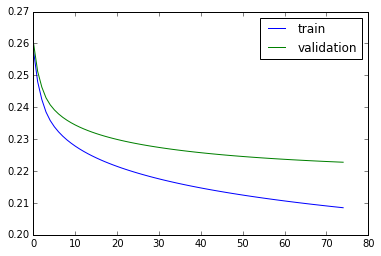

In [266]:
#softmax x ent logits, 128 hidden (16 before)
fig = plt.figure()
tr_plot, = plt.plot(range(75),tr_cost[1:],label='train')
val_plot, = plt.plot(range(75),val_cost[1:],label='validation')
plt.legend(handles=[tr_plot, val_plot]);

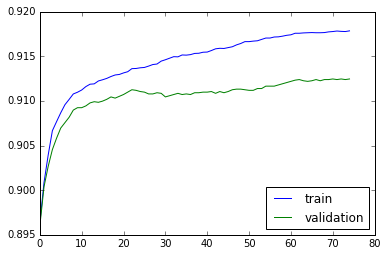

In [267]:
fig = plt.figure()
tr_plot, = plt.plot(range(75),tr_acc[1:],label='train')
val_plot, = plt.plot(range(75),val_acc[1:],label='validation')
plt.legend(handles=[tr_plot, val_plot],loc=4);

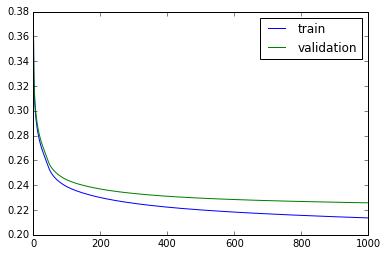

In [126]:
fig = plt.figure()
tr_plot, = plt.plot(range(1000),tr_cost[1:],label='train')
val_plot, = plt.plot(range(1000),val_cost[1:],label='validation')
plt.legend(handles=[tr_plot, val_plot]);

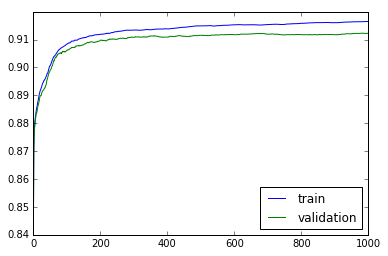

In [129]:
fig = plt.figure()
tr_plot, = plt.plot(range(1000),tr_acc[1:],label='train')
val_plot, = plt.plot(range(1000),val_acc[1:],label='validation')
plt.legend(handles=[tr_plot, val_plot],loc=4);

In [656]:
def predict(numpy_file):
    predictions = []
    # build graph and initialize session
    tf.reset_default_graph()
    #42 seconds next step
    (X,_),_,_,pred_y,_,_,saver = build_graph()
    
    with tf.Session() as sess:
        # 18 seconds
        sess.run(tf.initialize_all_variables())
        saver.restore(sess,'/Users/Rutherford/Desktop/rnn models/model.ckpt')
        # generate calculations from 2d array of input strings
        for row in numpy_file:
            str_1,str_2 = row[0],row[1]

            # strings identical
            if str_1 == str_2:
                predictions.append('No error')
                continue

            # model prediction
            try:
                #tf.arg_max(pred_y,1),
                pred = sess.run([tf.argmax(pred_y,1)],
                                feed_dict=\
                                {X: np.asarray(_get_dist(str_1,str_2)).reshape([-1,n_steps,n_input])})
                #print(pred)
                #predictions.append(str(pred[0][0]+1))
                predictions.append(pred[0][0]+1)

            # can't predict
            except:
                predictions.append('Unknown')
    
    return predictions
    #print(','.join(predictions))


In [657]:
raw_x_test = X_in[indices[_validation_test_split_idx:_train_test_split_idx]]

In [658]:
preds = predict(raw_x_test[:1000])

In [663]:
# spaces removed dataset
confusion_matrix(y_test_res[:1000],preds)

array([[677,  66],
       [136, 121]])

In [261]:
# negative ratio 75 runs
confusion_matrix(y_test_res[:1000],preds)

array([[133, 750],
       [ 11, 106]])

In [ ]:
#tf.less

In [242]:
# next negative 1-ratio
confusion_matrix(y_test_res[:1000],preds)

array([[ 30, 853],
       [  5, 112]])

In [236]:
# next negative ratio
confusion_matrix(y_test_res[:1000],preds)

array([[149, 734],
       [ 15, 102]])

In [230]:
# next 1-ratio
confusion_matrix(y_test_res[:1000],preds)

array([[883,   0],
       [111,   6]])

In [224]:
# ratio weight
confusion_matrix(y_test_res[:1000],preds)

array([[881,   2],
       [115,   2]])

In [216]:
# 1.05 weight 20 runs
confusion_matrix(y_test_res[:1000],preds)

array([[882,   1],
       [117,   0]])

In [209]:
# .05 weight 20 runs
confusion_matrix(y_test_res[:1000],preds)

array([[883,   0],
       [117,   0]])

In [203]:
# -.05 weight 20 runs
confusion_matrix(y_test_res[:1000],preds)

array([[ 93, 790],
       [ 10, 107]])

In [193]:
#-3.5 weight first run (accuracy goes down, unsurprisingly)
confusion_matrix(y_test_res[:1000],preds)

array([[ 14, 869],
       [  3, 114]])

In [178]:
#other weighted
confusion_matrix(y_test_res[:1000],preds)

array([[865,  18],
       [ 78,  39]])

In [169]:
# weighted
confusion_matrix(y_test_res[:1000],preds)

array([[866,  17],
       [ 81,  36]])

In [152]:
#978
confusion_matrix(y_test_res[:1000],preds)

array([[867,  16],
       [ 79,  38]])

In [153]:
np.where((np.asarray(preds)==1) & (y_test_res[:1000]==2))

(array([ 24,  34,  41,  44,  45,  60,  77,  87,  94, 108, 127, 149, 168,
        176, 185, 187, 191, 218, 222, 253, 279, 290, 305, 307, 313, 324,
        330, 346, 358, 375, 402, 417, 421, 440, 441, 459, 497, 504, 510,
        551, 562, 578, 605, 619, 625, 626, 641, 649, 654, 657, 673, 678,
        692, 701, 733, 750, 757, 762, 787, 802, 817, 820, 821, 825, 831,
        840, 855, 859, 876, 880, 909, 933, 942, 943, 947, 954, 975, 977, 981]),)

In [54]:
tester = np.genfromtxt('/Users/Rutherford/Desktop/data/data.csv',dtype='str',delimiter=',')

In [55]:
predict(tester)

2,1,1,1,2,1,2,No error,1,1,1,1,1,No error,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [120]:
from sklearn.metrics import confusion_matrix

def check_results(y_test,result_list):
    """
    Prints a confusion matrix of performance on the test set,
    and instantiates lists of True Positive, True Negative,
    False Positive, and False Negative for inspection as
    self._TP, self._TN, self._FP, self._FN.
    """

    # print confusion matrix
    #true_y_labels = np.array(y_test[:,1])
    true_y_labels = np.argmax(y_test,1)+1
    print('\t\tPredicted:')
    print('\t\tmin. maj.')
    print('Actual:\t min.',
          confusion_matrix(true_y_labels,result_list)[0])
    print('    \t maj.',
          confusion_matrix(true_y_labels,result_list)[1])

    # identify predicted and true positives and negatives
    predicted_pos = np.where(result_list[0]==1)
    predicted_neg = np.where(result_list[0]==0)
    actual_pos = np.where(np.argmax(y_test,1)==1)
    actual_neg = np.where(np.argmax(y_test,1)==0)

    # indices of shuffled and split data (just y_test)
    true_pos = np.intersect1d(predicted_pos,actual_pos).tolist()
    true_neg = np.intersect1d(predicted_neg,actual_neg).tolist()
    false_pos = np.intersect1d(predicted_pos,actual_neg).tolist()
    false_neg = np.intersect1d(predicted_neg,actual_pos).tolist()
    y_indices = indices[_validation_test_split_idx:
                                  _train_test_split_idx]

    raw_X = X_in
    
    # create lists of true and false positives and negatives
    TP = [list(raw_X[y_indices[i]]) for i in true_pos]
    TN = [list(raw_X[y_indices[i]]) for i in true_neg]
    FP = [list(raw_X[y_indices[i]]) for i in false_pos]
    FN = [list(raw_X[y_indices[i]]) for i in false_neg]


In [106]:
res = [1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,2,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [662]:
y_test_res = np.argmax(y_test,1)+1

In [102]:
confusion_matrix(y_test_res[:500],res)

array([[432,  10],
       [ 35,  23]])

In [1]:
# to see if there's a difference when n_input and n_steps are flipped
tf.reset_default_graph()
'''
To classify images using a recurrent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''

# Parameters
learning_rate = 0.001
training_iters = 10#0000
batch_size = 64
display_step = 1

# Network Parameters
n_input = 608 # MNIST data input (img shape: 28*28)
n_steps = 1 # timesteps
num_hidden = 4#128 # hidden layer num of features
n_classes = 2 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}
start = time()
pred = RNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    print('variables initialized ',time()-start)
    start_end = zip(range(0,len(x_train),batch_size),
               range(batch_size,len(x_train)+1,
                     batch_size))
    # Keep training until reach max iterations
    #while step * batch_size < training_iters:
    
    x_batch = x_train.reshape((-1,n_steps,n_input))
    print('x batch created ',time()-start)
    for pass_i in range(training_iters):
        for (s,e) in start_end:
            if str(s)[-2:] == '00':
                print(s,time()-start)
        
            """batch_x, batch_y = mnist.train.next_batch(batch_size)

            # Reshape data to get 28 seq of 28 elements
            batch_x = batch_x.reshape((batch_size, n_steps, n_input))"""
            
            ######x_batch = x_train[s:e,].reshape((batch_size,n_steps,n_input))
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: x_batch[s:e,:,:], y: y_train[s:e]})
            # Calculate batch accuracy
            #train_acc = sess.run(accuracy, feed_dict={x: x_batch, y: y_train[s:e]})
            # Calculate batch loss
            #train_loss = sess.run(cost, feed_dict={x: x_batch, y: y_train[s:e]})
            sess.run(accuracy, feed_dict={x: x_batch[s:e,:,:], y: y_train[s:e]})
        print('done minibatching')
        loss = sess.run(cost, feed_dict={x: x_batch, y: y_train})
        acc = sess.run(accuracy, feed_dict={x: x_batch, y: y_train})
        print("Iter " + str(pass_i) + ", Train Loss= " + \
              "{:.6f}".format(loss) + ", Train Accuracy= " + \
              "{:.5f}".format(acc))
        #if pass_i % display_step == 0:
        #    x_test_correct_shape = x_train.reshape((-1, n_steps, n_input))
        #    # Calculate batch accuracy
        #    acc = sess.run(accuracy, feed_dict={x: x_test_correct_shape, y: y_test})
        #    # Calculate batch loss
        #    loss = sess.run(cost, feed_dict={x: x_test_correct_shape, y: y_test})
        #    print("Iter " + str(pass_i) + ", Test Loss= " + \
        #          "{:.6f}".format(loss) + ", Test Accuracy= " + \
        #          "{:.5f}".format(acc))
    print("Optimization Finished!")

NameError: name 'tf' is not defined

In [ ]:
# inputs and outputs (latter are one-hot vectors)
X = tf.placeholder(tf.float32, shape=[None,608])#612])#12])#"""612])"""
Y = tf.placeholder(tf.float32, shape=[None,2])
lr = tf.placeholder(tf.float32)
glob_step = tf.Variable(0,dtype=tf.float32,trainable=False)

weight_shape1 = [608,256]#612 #"""12"""
weight_shape2 = [256,128]
weight_shape3 = [128,16]
weight_shape4 = [16,2]

[n_inputs1,n_outputs1,n_inputs3,n_outputs3,n_outputs_final] =             weight_shape1[0],weight_shape1[1],weight_shape3[0],             weight_shape3[1],weight_shape4[1]

init_range1 = tf.sqrt(6.0/(n_inputs1+n_outputs1))
init_range2 = tf.sqrt(6.0/(n_outputs1+n_inputs3))
init_range3 = tf.sqrt(6.0/(n_inputs3+n_outputs3))
init_range4 = tf.sqrt(6.0/(n_outputs3+n_outputs_final))
w1 = tf.Variable(tf.random_uniform(weight_shape1,
                                   -init_range1,init_range1),name='w1')
w2 = tf.Variable(tf.random_uniform(weight_shape2,
                                   -init_range2,init_range2),name='w2')
w3 = tf.Variable(tf.random_uniform(weight_shape3,
                                   -init_range3,init_range3),name='w3')
w4 = tf.Variable(tf.random_uniform(weight_shape4,
                                   -init_range4,init_range4),name='w4')
b = tf.Variable(tf.constant(.1,shape=[n_outputs_final]))


# network - batch normalization in training, relu activations
dot1 = tf.matmul(X,w1)
batch_normed1 = self._batch_norm_wrapper(dot1,training)
rel1 = tf.nn.relu(batch_normed1)

dot2 = tf.matmul(rel1,w2)
batch_normed2 = self._batch_norm_wrapper(dot2,training)
rel2 = tf.nn.relu(batch_normed2)

dot3 = tf.matmul(rel2,w3)
batch_normed3 = self._batch_norm_wrapper(dot3,training)
rel3 = tf.nn.relu(batch_normed3)

# softmax layer
logits = tf.matmul(rel3,w4)+b
probs_x = tf.nn.softmax(logits)

# cost:
#    per pair
rows_of_cost =             tf.nn.softmax_cross_entropy_with_logits(logits,Y,
                                            name='rows_of_cost')
#    average over all pairs
cost = tf.reduce_mean(rows_of_cost,reduction_indices=None,
                      keep_dims=False,name='cost')

# gradients and training
opt = tf.train.AdagradOptimizer(learning_rate=lr)
train_op = opt.minimize(cost,global_step=glob_step,
                        var_list=[w1,w2,w3,w4,b])

# predictions and accuracy
correct_prediction = tf.equal(tf.arg_max(probs_x,1),tf.arg_max(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#return (X,Y),cost,train_op,accuracy,probs_x,lr,tf.train.Saver()


In [ ]:
import tensorflow as tf
import numpy as np
import sys
from rnnRecurrenceFcn import fLSTM

log_dir = "logs/"

tf.reset_default_graph()

def data_gen(batch_size, seq_len):
    x = np.array(np.random.normal(size=(batch_size, seq_len)), dtype=np.float32)
    #x = np.ones((batch_size, seq_len), dtype=np.float32)
    y = np.sum(x, axis=1)
    x = x.reshape([batch_size, seq_len, 1])
    y = y.reshape([batch_size, 1])
    return x, y

#replace with placeholders
inputSize = 1
hiddenSize = 32
targetSize = 1
mBatch = 100

input_size = inputSize
hidden_size = hiddenSize
target_size = targetSize

# Weights for output layers
Wo = tf.Variable(tf.truncated_normal([hidden_size, target_size], mean=0, stddev=.01), name="Wo")
bo = tf.Variable(tf.truncated_normal([target_size], mean=0, stddev=.01), name="bo")

initHidden = tf.placeholder(tf.float32, shape = [None, 2*hidden_size])
inputs = tf.placeholder(tf.float32, shape=[None, None, input_size], name='inputs')
inputs_ = tf.transpose(inputs, perm=[1,0,2])

y = tf.placeholder(tf.float32, shape=[None, target_size])

initial_hidden = initHidden
print(initial_hidden)
#define recursion for scan function
fRScan = fLSTM(inputSize, hiddenSize)

#hidden state sequence
all_hidden_states = tf.scan(fRScan, inputs_, initializer=initial_hidden, name="LSTMStates")

#extract last hidden state
last_hidden_state = tf.reverse(all_hidden_states, [True, False, False])[0, :, :]
lastH, lastC = tf.split(1, 2, last_hidden_state)
#develop logit from last hidden state
last_output = tf.matmul(lastH, Wo) + bo

#loss definition for gradients
loss = tf.reduce_mean(tf.square(y - last_output))

#rms error for printing
rms_error = tf.sqrt(loss)

#training function
train_step = tf.train.AdamOptimizer().minimize(loss)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    #summary_op = tf.merge_all_summaries()
    writer = tf.train.SummaryWriter(log_dir, sess.graph)
    #print("initial_hidden: %s" % initial_hidden)
    # initial value for hidden state
    # Keep this value to start for zero for all subsequent iterations
    # Set to lastHiddenState after each training step
    iHid = np.zeros([mBatch, 2*hiddenSize], dtype=np.float32)
    print(iHid.shape)

    for epoch in range(4096):  # 120
        X_train, y_train = data_gen(mBatch, 10)
        X_test, y_test = data_gen(mBatch, 10)
        ts, lhs = sess.run([train_step, last_hidden_state], {inputs: X_train, y: y_train, initHidden: iHid})
        #iHid = lhs  #This line initializes each LSTM with the value at the end of last sequence of iterations
        #writer.add_summary(summary_str, epoch)

        Loss = str(sess.run(loss, {inputs: X_train, y: y_train, initHidden: iHid}))
        Train_error = str(sess.run(rms_error, {inputs: X_train, y: y_train, initHidden: iHid}))
        Test_error = str(sess.run(rms_error, {inputs: X_test, y: y_test, initHidden: iHid}))

        sys.stdout.flush()
        print("\rIteration: %s Loss: %s Train Error: %s Test Error: %s" %
              (epoch, Loss, Train_error, Test_error)),
    sys.stdout.flush()